In [8]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [9]:
try:
    df_train = pd.read_csv('final_train_features.csv')
    df_test = pd.read_csv('final_test_features.csv')
    test_id = pd.read_csv('test_ids.csv').iloc[:, 0]
    print("Final feature sets loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: Final feature files not found. Run '02_feature_engineering.py' first. ({e})")
    exit()


Final feature sets loaded successfully.


In [10]:
target_col = 'log_num_orders'
ignore_cols = ['id', 'num_orders', target_col, 'base_price', 'checkout_price', 'discount']
features = [col for col in df_train.columns if col not in ignore_cols]

X = df_train[features]
y = df_train[target_col]
X_test = df_test[features]

X_test = X_test[X.columns]
print(f"Using {len(features)} features for modeling.")


Using 16 features for modeling.


In [11]:
MAX_WEEK = X['week'].max()
VALIDATION_WEEKS = 10 
validation_week_start = MAX_WEEK - VALIDATION_WEEKS + 1

X_train_final = X[X['week'] < validation_week_start]
y_train_final = y[X['week'] < validation_week_start]
X_val = X[X['week'] >= validation_week_start]
y_val = y[X['week'] >= validation_week_start]

print(f"Total Weeks: 1 to {MAX_WEEK}")
print(f"Train Weeks: 1 to {validation_week_start - 1} ({X_train_final.shape[0]} rows)")
print(f"Validation Weeks: {validation_week_start} to {MAX_WEEK} ({X_val.shape[0]} rows)")



Total Weeks: 1 to 145
Train Weeks: 1 to 135 (423727 rows)
Validation Weeks: 136 to 145 (32821 rows)


In [12]:
print("\nStarting XGBoost Training...")
dtrain = xgb.DMatrix(X_train_final, label=y_train_final)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'eta': 0.05,            
    'max_depth': 8,
    'subsample': 0.8,      
    'colsample_bytree': 0.8, 
    'seed': 42,
    'tree_method': 'hist'  
}

model = xgb.train(
    params,
    dtrain,
    num_boost_round=1500, 
    evals=[(dval, 'val')],
    early_stopping_rounds=50, 
    verbose_eval=100
)

print(f"\nTraining finished. Best iteration: {model.best_iteration}")



Starting XGBoost Training...
[0]	val-rmse:1.11073
[100]	val-rmse:0.51658
[195]	val-rmse:0.51303

Training finished. Best iteration: 145


In [13]:
val_log_preds = model.predict(dval, iteration_range=(0, model.best_iteration))
val_preds = np.expm1(val_log_preds)
val_rmse = np.sqrt(mean_squared_error(df_train.loc[X_val.index, 'num_orders'], val_preds))
print(f"Validation RMSE on 'num_orders' (original scale): {val_rmse:.2f}")

Validation RMSE on 'num_orders' (original scale): 126.50


In [14]:
print("\nGenerating final test predictions...")
log_predictions = model.predict(dtest, iteration_range=(0, model.best_iteration))

predictions = np.expm1(log_predictions)

predictions[predictions < 0] = 0
final_predictions = np.round(predictions).astype(int)

submission_df = pd.DataFrame({
    'id': test_id,
    'num_orders': final_predictions
})

submission_filepath = 'food_demand_submission.csv'
submission_df.to_csv(submission_filepath, index=False)

print(f"\nSUCCESS: Submission file saved to '{submission_filepath}'")
print("\nTop 5 predictions:")
print(submission_df.head())


Generating final test predictions...

SUCCESS: Submission file saved to 'food_demand_submission.csv'

Top 5 predictions:
        id  num_orders
0  1028232         167
1  1127204         167
2  1212707         125
3  1082698          40
4  1400926          30


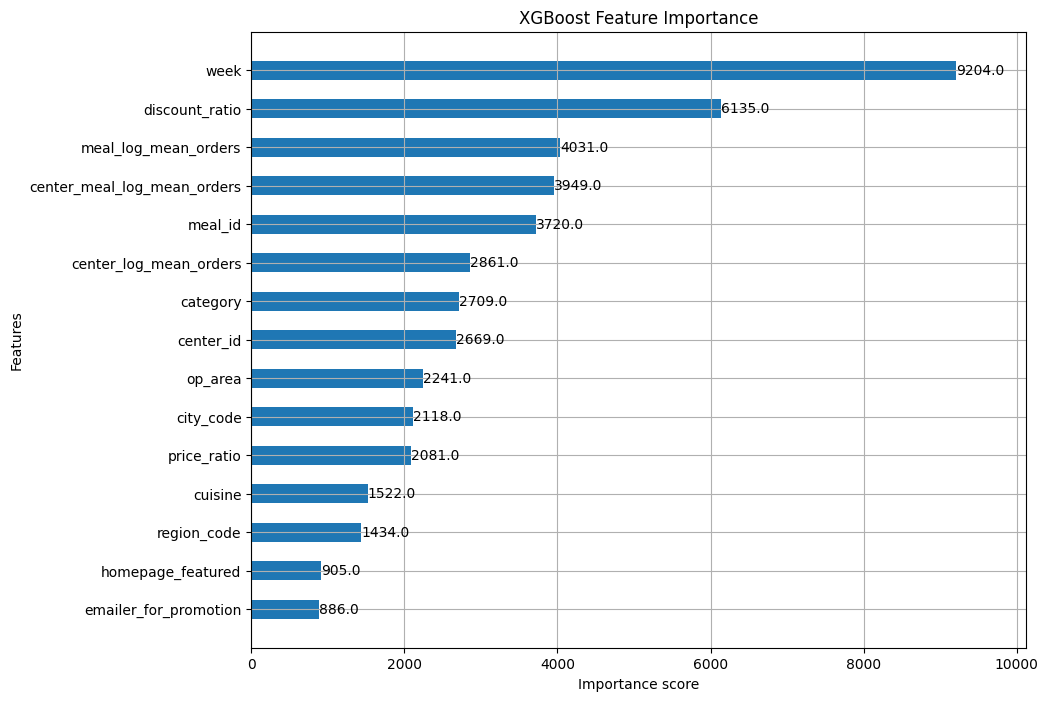

In [15]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=15, height=0.5, ax=ax, title='XGBoost Feature Importance')
plt.show()